Sprint 14. Series Temporales. 
---
La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

In [4]:
#Importamos las librerias necesarias para realizar el proyecto. 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [5]:
"""Importamos el dataset csv y asignamos como indices a la columna con los datos de tiempo,
donde reordenaremos los datos conforme al indice, tambien
revisamos su informacion y las primeras 10 filas de estos datos. """

data = pd.read_csv('dataset/taxi.csv', index_col=[0],parse_dates=[0])
data.sort_index(inplace= True)
data.info()
print(data.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12


In [6]:
#Revisar si tenemos valores nulos. 
print(data.isna().sum())

num_orders    0
dtype: int64


In [8]:
"""Reasignamos el dataset sumando los datos de cada conjunto de hora para tener
los datos por intervalos de una hora. Esta es la variable (data_hour) con la que 
realizaremos los entrenamientos en cada modelos y asi poder seleccionar el mejor. """ 

data_hour = data.resample('1H').sum()
data_hour.info()
print(data_hour.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


C:\Users\jimen\AppData\Local\Temp\ipykernel_22908\1670782366.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hour = data.resample('1H').sum()


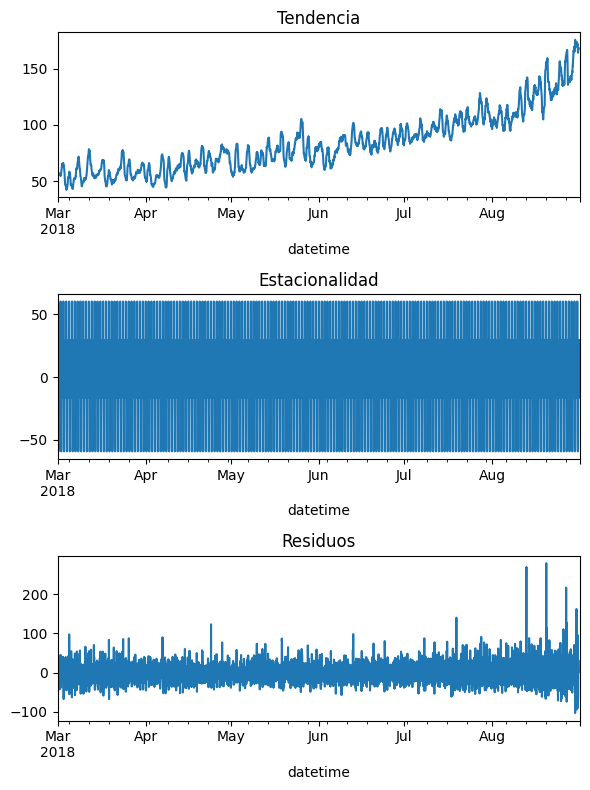

In [9]:
"""Llamamos a la funcion seasonal decompose para
poder ver la tendencia, la estacionalidad y los residuios del dataset
por intervalo de hora. """

decomposed = seasonal_decompose(data_hour)

plt.figure(figsize= (6,8))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title("Tendencia")
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title("Estacionalidad")
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title("Residuos")
plt.tight_layout()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4393 non-null   float64
 2   rolling_std   4393 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 267.0 KB
                     num_orders  rolling_mean  rolling_std
datetime                                                  
2018-03-01 00:00:00         124           NaN          NaN
2018-03-01 01:00:00          85           NaN          NaN
2018-03-01 02:00:00          71           NaN          NaN
2018-03-01 03:00:00          66           NaN          NaN
2018-03-01 04:00:00          43           NaN          NaN


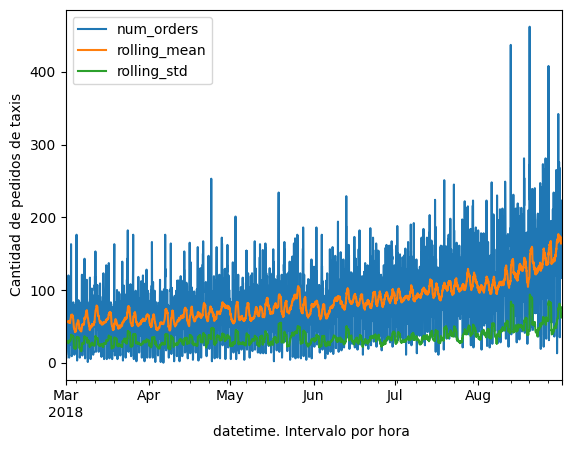

In [23]:
"""Se creó la columna para la media movil y la columna estandar movil 
de cada 24 filas para poder visualizar los valores de cada día con mejor claridad, 
ya que los intervalos son cada hora, obtendremos NaN en las primeras
24 filas. En el grafico se puede visualizar mejor los picos de subida y de bajada 
despues de cada cierto tiempo. """

data_hour['rolling_mean'] = data_hour['num_orders'].rolling(24).mean()
data_hour['rolling_std'] = data_hour['num_orders'].rolling(24).std()
data_hour.info()
print(data_hour.head())
data_hour.plot()
plt.ylabel('Cantidad de pedidos de taxis')
plt.xlabel('datetime. Intervalo por hora ')
plt.show()

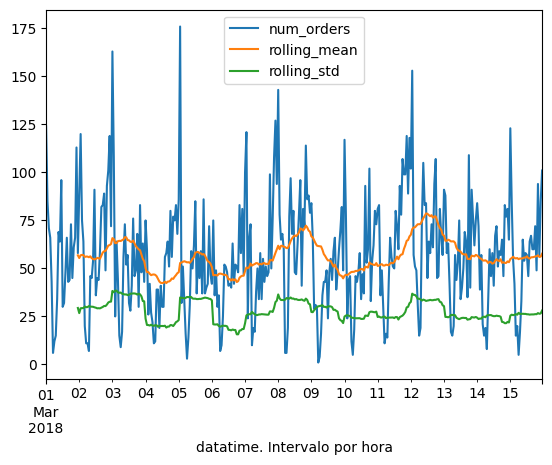

In [11]:
"""Veamos una sección de 15 días de los datos, para poder ver como se mueve 
la media y la distribucion estandar movil a una escala. 
"""
data_hour['2018-03-01 00:00:00':'2018-03-15 23:00:00'].plot()
plt.xlabel('datatime. Intervalo por hora')
plt.ylabel('Cantidad de pedidos de taxis')
plt.show()

Al dividir el dataset en intervalos por hora, tenemos 4416 filas con registros de taxis solicitados, donde antes teniamos 26496 registros por cada 10 mins.
No tuvimos ningun valor faltante por lo que no tenemos que eliminar o agregar ningun valor hasta ahora.  

Para conocer mas los datos vamos a dividir los datos por intervalos por día y mes.
Incluiremos el valor de media y desviacion estandar movil para poder ver observar con mayor detalle como se mueven los datos. 


In [12]:
"""Generamos el dataset por intevalos por día. Tenemos los mismos datos 
que en el dataset de por hora, pero teniendo un total de todas las horas 
de ese día."""

data_day = data.resample('1D').sum()
data_day.info()
print(data_day)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2018-03-01 to 2018-08-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  184 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB
            num_orders
datetime              
2018-03-01        1364
2018-03-02        1506
2018-03-03        1290
2018-03-04        1141
2018-03-05        1259
...                ...
2018-08-27        3936
2018-08-28        3357
2018-08-29        3762
2018-08-30        4090
2018-08-31        4018

[184 rows x 1 columns]


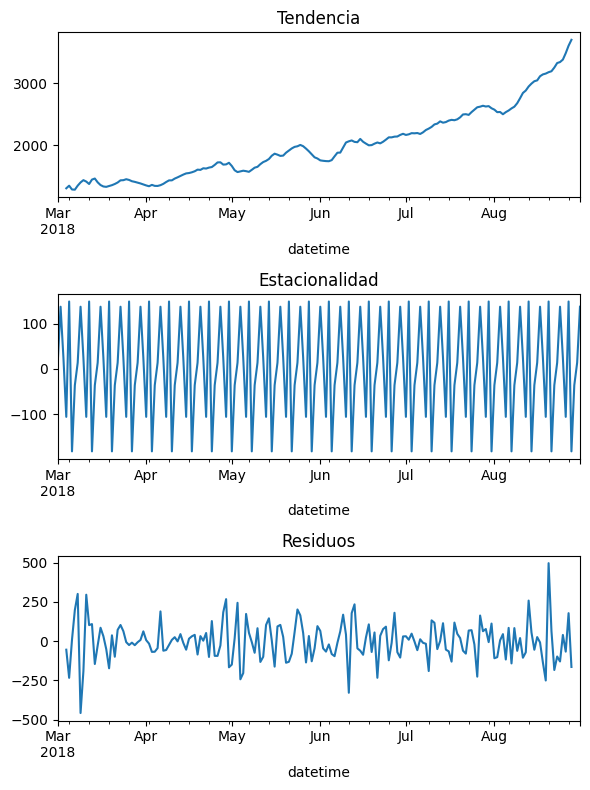

In [13]:
"""Realizamos la misma descomposicion de los datos para calcular
la estacionalidad, la tendencia y el ruido pero por cada día. """
decomposed_day = seasonal_decompose(data_day)
plt.figure(figsize= (6,8))
plt.subplot(311)
decomposed_day.trend.plot(ax = plt.gca())
plt.title("Tendencia")
plt.subplot(312)
decomposed_day.seasonal.plot(ax = plt.gca())
plt.title("Estacionalidad")
plt.subplot(313)
decomposed_day.resid.plot(ax = plt.gca())
plt.title("Residuos")

plt.tight_layout()

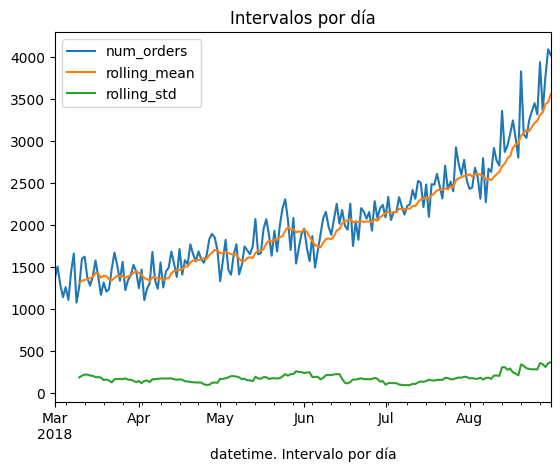

In [ ]:
"""Crear las columnas de la media y la desviacion estandar del data ser 
por día con un conjunto de 10 filas. Podemos ver los datos iguales al dataset
por hora pero con menos fluctiaciones. """

data_day['rolling_mean'] = data_day['num_orders'].rolling(10).mean()
data_day['rolling_std'] = data_day['num_orders'].rolling(10).std()
data_day.plot()
plt.title('Intervalos por día')
plt.ylabel('Cantidad de pedidos de taxis')
plt.xlabel('datetime. Intervalo por día')
plt.show()

In [21]:
"""Y por ultimo, crear el dataset por mes para visualizar los datos de 
forma mas general. """
data_month = data.resample('1M').sum()
data_month.info()
print(data_month)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2018-03-31 to 2018-08-31
Freq: ME
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  6 non-null      int64
dtypes: int64(1)
memory usage: 96.0 bytes
            num_orders
datetime              
2018-03-31       42768
2018-04-30       45939
2018-05-31       54820
2018-06-30       59906
2018-07-31       74405
2018-08-31       94973


C:\Users\jimen\AppData\Local\Temp\ipykernel_22908\443759135.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_month = data.resample('1M').sum()


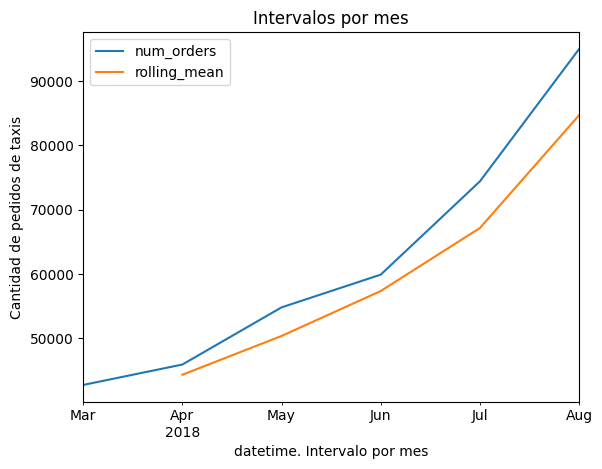

In [22]:
""""""
data_month['rolling_mean'] = data_month.rolling(2).mean()
data_month.plot()
plt.title('Intervalos por mes')
plt.xlabel('datetime. Intervalo por mes')
plt.ylabel('Cantidad de pedidos de taxis')
plt.show()

**OBSERVACIONES**

Agosto es el mes con mas pedidos de taxis con un total de 94973 pedidos y Marzo es el mes con menos perdidos de taxi con 42768.
Se crearon las graficas de tendencia, estacionalidad y residuos y tambien se calcularon las medias y desaviaciones estandar moviles de cada unos de los diferentes intervalos, estos intervalos tienen los mismo datos pero podemos verlos con menos fluctuaciones y mas generales. 

Podemos ver que la tendecia en los pedidos de los taxis va en aumento por cada mes desde marzo a agosto. 
De igual forma, al ver en la grafica de estacionalidad existen fluctiacions constantes y en la de desviacion estandar podemos ver que no hay cambios en el tiempo. Esto quiere decir que tenemos una seria estacionaria, por lo que podems pronosticar los datos sin ningun problema.


In [24]:
data_hour_temporal = data.resample('1H').sum()
data_hour_temporal -= data_hour_temporal.shift()
data_hour_temporal.head()

C:\Users\jimen\AppData\Local\Temp\ipykernel_22908\3633655119.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hour_temporal = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,-39.0
2018-03-01 02:00:00,-14.0
2018-03-01 03:00:00,-5.0
2018-03-01 04:00:00,-23.0
